In [ ]:
'''
.....IMPORTANT USAGE INSTRUCTIONS........

##### IF USING CHPC - UTAH #####

1. Download this Jupyter Notebook to a local location on your Computer
2. Go to https://ondemand.chpc.utah.edu and sign in using your uNID and Password.
3. At the Top of the Page, notice the Menu "Interactive Apps". Click and Choose "Jupyter Notebook on Notchpeak"
4. A form will open, enter all details, and then Launch a Jupyter Notebook. It will take a minute.
5. Click on "Connect to Jupyter"
6. Once Jupyter Launches. On Top Right Notice "Upload Button". Use this to Upload this Notebook.
7. The Notebook will be uploaded. Finish writing the Code whereever specified.
8. Run each Block of Code and then finally download the Jupyter Notebook by going to File >> Download as >>


##### IF USING GOOGLE COLAB #####

1. Download this Jupyter Notebook to a local location on your Computer
2. Go to https://colab.research.google.com/ and sign in using your Google Account - So that your work is saved in
   your Google Drive permanently.
3. Go to File >> Upload Notebook.
4. Finish writing the Code whereever specified.
5. Run each Block of Code ad then finally download the Jupyter Notebook by going to File >> Download .ipynb

'''

In [ ]:
'''
.....IMPORTANT SUBMISSION INSTRUCTIONS........

Once everything runs successfully, download the jupyter notebook and attach that to your submission in Canvas. 
During evaluation, I will run your Jupyter Notebook to verify that everything is running as expected.

Do not forget to include your main results and plots in your latex file (with other homework questions) 
before submission.

'''

In [ ]:
'''

Problem 6.1

'''

In [2]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from collections import Counter
from sklearn.utils import shuffle

# Matplotlib Settings with ggplot Theme
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Fixing random state for reproducibility
np.random.seed(19680801)

In [4]:
# Data Import and Preprocessing

'''
Note : The dataset data_seed.dat can be downloaded from Canvas or github. In this notebook, I have placed this file
       directly under my home directory indicated by ~/.
       
       In CHPC - Your home directory is /uufs/cpc.utah.edu/common/home/<uNID>
       
       In Google Colab - On the Left Hand Menu, Click on Files and then Upload this data file.

'''

# Import Data File into Pandas - 210 Rows and 8 Columns. The dataset has no column names
df = pd.read_csv('data_seed.dat', sep = '\s+', header = None, skiprows = 0)

# Add Column Names
df.columns = ['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv','Y']

# Scale X Columns -  The idea is to Scale each column in the dataset using built in Standard Scaler
cols_to_norm = ['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

In [5]:
# Let's Check how the dataset looks like
df.head()

,A,P,C,L_Kern,W_Kern,Asy_Coeff,L_Kern_Grv,Y
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,1
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,1
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,1
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,1
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,1


In [6]:
'''

The Logic behind k-NN

i. You want to learn k closest neighbors of any given point and assign to that point the most common class 
(by majority vote) found in the neighborhood as defined by the closest k points. Computationally, 
k-NN is called  Lazy method because there is actually no training involved, which means, that
given a set of points with known classes (y), you can directly predict the class of a new point given that
you have y. 

ii. However, the question is how do we know what the value of "k" should be? The answer is that we do not know this 
apriori. Hence we have to do a grid search on a set of candidate values of "k" and use a resampling method such as 
5 fold CV or LOOCV (leave-one-out-of cross validation) to get a more robust answer

iii. In the context of this problem, we consider both cases i.e. (a) 5 fold CV, (b) LOOCV

(a) 5 fold CV - We create the 5 folds. We make 5 passes through the data. In each pass, we reserve 
one fold and use the other 4 folds to predict the classes of the held out fold. We then use the prediction and the 
true label to compute an accuracy for that pass. At the end of 5 passes, we average out the accuracy and
report is as the 5 fold cross validated accuracy

(b) LOOCV - Same as above. Just that instead of 5 passes we have to make "n" (Size of the dataset) passes because in
each pass we predict a [1 (true label matches predicted), 0(otherwise)] score for just one data point that is held out
using the others to predict the class of the held out datapoint. In the end we count the number of 1's and divide by n 
to get the accuracy.

'''

'\n\nThe Logic behind k-NN\n\ni. You want to learn k closest neighbors of any given point and assign to that point the most common class \n(by majority vote) found in the neighborhood as defined by the closest k points. Computationally, \nk-NN is called  Lazy method because there is actually no training involved, which means, that\ngiven a set of points with known classes (y), you can directly predict the class of a new point given that\nyou have y. \n\nii. However, the question is how do we know what the value of "k" should be? The answer is that we do not know this \napriori. Hence we have to do a grid search on a set of candidate values of "k" and use a resampling method such as \n5 fold CV or LOOCV (leave-one-out-of cross validation) to get a more robust answer\n\niii. In the context of this problem, we consider both cases i.e. (a) 5 fold CV, (b) LOOCV\n\n(a) 5 fold CV - We create the 5 folds. We make 5 passes through the data. In each pass, we reserve \none fold and use the other 

In [28]:
# Define X, y
X = df[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']]
y = df['Y']

# import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

'''        
Step - build a knn model with k = 1, 5, 10, 15, use 5-fold cv
'''

data_partitions = np.array_split(df.sample(frac=1), 5)

k_values = [1, 5, 10, 15]

fold_scores = np.zeros(len(k_values))

for i,k in enumerate(k_values):
    scores = []
    for j in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        test = data_partitions[j]
        train = pd.concat(data_partitions[:j] + data_partitions[j+1:])
        
        knn.fit(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
        score = knn.score(test[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], test['Y'])
        scores.append(score)
    
    print("k = ", k, "average accuracy = ", np.mean(scores))
    fold_scores[i] = np.mean(scores)
        


k =  1 average accuracy =  0.9285714285714286
k =  5 average accuracy =  0.9238095238095237
k =  10 average accuracy =  0.9333333333333333
k =  15 average accuracy =  0.9285714285714286


/usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [36]:
'''        
Step - build a knn model with k = 1, 5, 10, 15, use LOOCV
'''

loocv_scores = np.zeros(len(k_values))

for i, k in enumerate(k_values):
    scores = []
    for j in range(len(df)):
        knn = KNeighborsClassifier(n_neighbors=k)
        test = df.iloc[[j]]
        train = df.iloc[[i for i in range(len(df)) if i != j]]
        knn.fit(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
        
        score = knn.score(test[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], test['Y'])
        scores.append(score)
    
    print("k = ", k, "average accuracy = ", np.mean(scores))
    loocv_scores[i] = np.mean(scores)
 

k =  1 average accuracy =  0.9380952380952381
k =  5 average accuracy =  0.9333333333333333
k =  10 average accuracy =  0.919047619047619
k =  15 average accuracy =  0.919047619047619


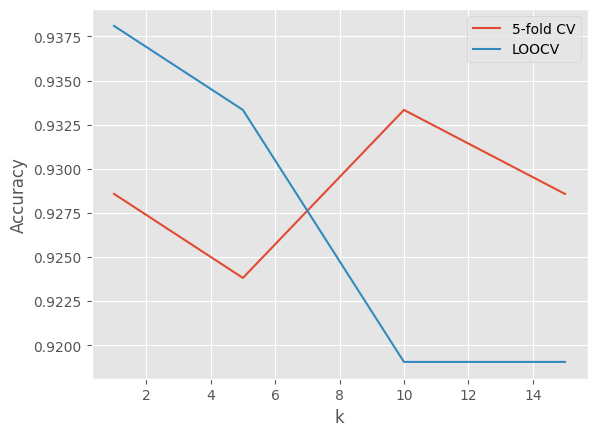

In [38]:
'''
Step
Line plot of errors for each k for 5 fold CV
Line plot of errors for each k for LOOCV

Remark:

Make sure the plot is properly labeled.

'''

plt.plot(k_values, fold_scores, label = "5-fold CV")
plt.plot(k_values, loocv_scores, label = "LOOCV")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()


In [40]:
'''
Problem 6.2 -- 

Apply logistic regression, SVM, and random forest. The sequence of steps will be roughly the same to the knn.

'''

# import packages
from sklearn.linear_model import LogisticRegression


# Randomly split the data into 5 folds
data_partitions = np.array_split(df.sample(frac=1), 5)


# Logistic Regression
log_scores = []
for j in range(5):
    clf = LogisticRegression()
    test = data_partitions[j]
    train = pd.concat(data_partitions[:j] + data_partitions[j+1:])
    
    clf.fit(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
    score = clf.score(test[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], test['Y'])
    log_scores.append(score)

print("Logistic Regression average accuracy = ", np.mean(log_scores))

Logistic Regression average accuracy =  0.9238095238095239


/usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [46]:
# import packages
from sklearn.svm import SVC


# Randomly split the data into 5 folds
data_partitions = np.array_split(df.sample(frac=1), 5)


# Logistic Regression
svm_scores = []
for j in range(5):
    svm = SVC()
    test = data_partitions[j]
    train = pd.concat(data_partitions[:j] + data_partitions[j+1:])

    svm.fit(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
    score = svm.score(test[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], test['Y'])
    svm_scores.append(score)

print("SVM average accuracy = ", np.mean(svm_scores))

SVM average accuracy =  0.9380952380952381


/usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [57]:
# import packages
from sklearn.ensemble import RandomForestClassifier


# Randomly split the data into 5 folds
data_partitions = np.array_split(df.sample(frac=1), 5)

number_of_trees = np.linspace(10, 300, 20, dtype=int)

# Logistic Regression
tree_scores = []
for i, n in enumerate(number_of_trees):
    train_scores = []
    test_scores = []
    for j in range(5):
        forest = RandomForestClassifier(n_estimators=n)
        test = data_partitions[j]
        train = pd.concat(data_partitions[:j] + data_partitions[j+1:])
        
        forest.fit(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
        
        test_score = forest.score(test[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], test['Y'])
        test_scores.append(test_score)

        train_score = forest.score(train[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']], train['Y'])
        train_scores.append(train_score)


    tree_scores.append(np.mean(scores))
    print(f"n = {n}, train score = {np.mean(train_scores)}, test score = {np.mean(test_scores)}")

/usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


n = 10, train score = 0.9964285714285716, test score = 0.9190476190476191
n = 25, train score = 1.0, test score = 0.9333333333333333
n = 40, train score = 1.0, test score = 0.9333333333333333
n = 55, train score = 1.0, test score = 0.9428571428571428
n = 71, train score = 1.0, test score = 0.9380952380952381
n = 86, train score = 1.0, test score = 0.9476190476190476
n = 101, train score = 1.0, test score = 0.9333333333333333
n = 116, train score = 1.0, test score = 0.9380952380952381
n = 132, train score = 1.0, test score = 0.9428571428571428
n = 147, train score = 1.0, test score = 0.9285714285714286
n = 162, train score = 1.0, test score = 0.9476190476190476
n = 177, train score = 1.0, test score = 0.9333333333333333
n = 193, train score = 1.0, test score = 0.9238095238095239
n = 208, train score = 1.0, test score = 0.9380952380952381
n = 223, train score = 1.0, test score = 0.9333333333333333
n = 238, train score = 1.0, test score = 0.9380952380952381
n = 254, train score = 1.0, tes